## Bruiter notre image et la décomposer en 3 cannaux :

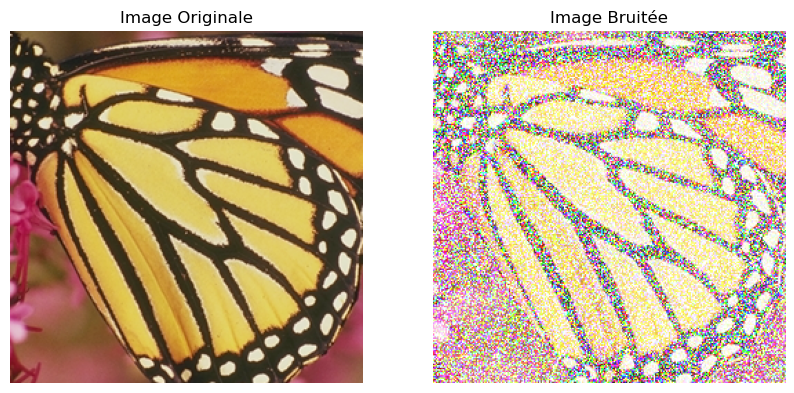

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def add_gaussian_noise(image, mean=0, sigma=25):

    # Générer du bruit gaussien pour chaque canal
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)  # Ajouter le bruit à l'image
    return noisy_image

# Chargement de l'image couleur
image_color = cv2.imread('butterfly.png')

# Ajouter du bruit à l'image couleur
noisy_image_color = add_gaussian_noise(image_color)

# Affichage des images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image Bruitée')
plt.imshow(cv2.cvtColor(noisy_image_color, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


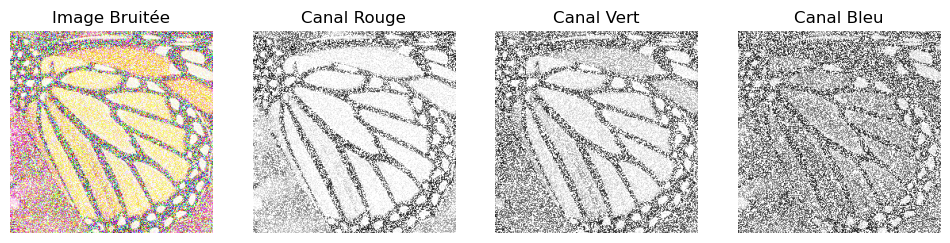

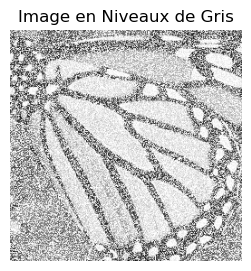

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split_channels(image):
   
    b, g, r = cv2.split(image)  # OpenCV lit les images en BGR
    return r, g, b

def rgb_to_gray(image):
  
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Décomposer l'image bruitée en canaux
r_channel, g_channel, b_channel = split_channels(noisy_image_color)

# Conversion de l'image bruitée en niveaux de gris
image_gray = rgb_to_gray(noisy_image_color)

# Affichage des canaux et de l'image en niveaux de gris
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.title('Image Bruitée')
plt.imshow(cv2.cvtColor(noisy_image_color, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Canal Rouge')
plt.imshow(r_channel, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Canal Vert')
plt.imshow(g_channel, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Canal Bleu')
plt.imshow(b_channel, cmap='gray')
plt.axis('off')

plt.figure(figsize=(6, 3))
plt.title('Image en Niveaux de Gris')
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
cv2.imwrite('image_niveaux_de_gris.jpg', image_gray)
plt.show()


## Programmation de la methode de prox  :

In [27]:
from numba import jit, float64, void, int64
import numpy as np


@jit(void(float64[:, :, :], float64[:]), cache=True, nopython=True)
def svt(input_array, tau):
    for k in range(input_array.shape[-1]):
        u, d, v = np.linalg.svd(input_array[..., k],
                                full_matrices=False)  # ideally we should use the option compute_uv=False, but jit doesn't allow us this
        d_ = np.zeros_like(d)
        for idx in range(len(d)):
            if d[idx] > tau[k]:
                d_[idx] = d[idx] - tau[k]
            else:
                break
        input_array[..., k] = u @ np.diag(d_) @ v


@jit(float64[:, :, :](float64[:, :]), fastmath=True, nopython=True)
def D(input_array):
    output = np.ascontiguousarray(np.zeros(input_array.shape + (2,)))
    output[:-1, :, 0] = input_array[1:, :] - input_array[:-1, :]  # grad x
    output[:, :-1, 1] = input_array[:, 1:] - input_array[:, :-1]  # grad y
    return output


@jit(float64[:, :](float64[:, :, :]), fastmath=True, nopython=True)
def div(input_array):
    div_x = np.ascontiguousarray(np.zeros(input_array.shape[:2]))
    div_y = np.ascontiguousarray(np.zeros(input_array.shape[:2]))

    div_x[1:-1, :] = input_array[1:-1, :, 0] - input_array[:-2, :, 0]
    div_x[0, :] = input_array[0, :, 0]
    div_x[-1, :] = -input_array[-2, :, 0]

    div_y[:, 1:-1] = input_array[:, 1:-1, 1] - input_array[:, :-2, 1]
    div_y[:, 0] = input_array[:, 0, 1]
    div_y[:, -1] = -input_array[:, -2, 1]

    return div_x + div_y


@jit(float64[:, :, :](float64[:, :, :], float64[:, :], float64), fastmath=True, cache=True,
     nopython=True)
def grad_F_tv(y, x, h):
    return 2 * D(x / h - div(y))


@jit(float64[:, :, :](float64[:, :, :]), fastmath=True, cache=True, nopython=True)
def project_unit(z):
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            norm_z = np.sqrt(z[i, j, 0] ** 2 + z[i, j, 1] ** 2)
            if norm_z > 1:
                z[i, j, 0] = z[i, j, 0] / norm_z
                z[i, j, 1] = z[i, j, 1] / norm_z
    return z


@jit(float64[:, :](float64[:, :], float64, int64), fastmath=True, cache=True, nopython=True)
def _prox_tv(x, h, nb_iter=200):
    w = np.ascontiguousarray(np.zeros(x.shape + (2,)))
    y = w
    t = 1
    h_tv = 0.08  # optimal step for the computations
    # Accelerated Projection algorithm
    for _ in range(nb_iter):
        w_prev = w
        w = project_unit(y - h_tv * grad_F_tv(y, x, h))
        t_prev = t
        t = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = w + ((t_prev - 1) / t) * (w - w_prev)
    return x - h * div(w)


@jit(void(float64[:, :, :], float64[:], int64), nopython=True)
def prox_tv(x, h, nb_iter=200):
    for idk in range(x.shape[-1]):
        x[..., idk] = _prox_tv(x[..., idk], h[idk], nb_iter=nb_iter)


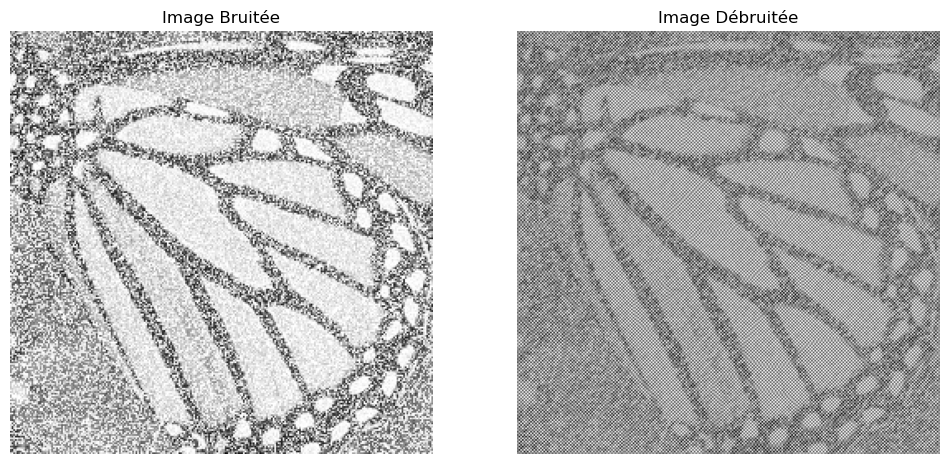

True

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, float64, void

# Calculer le gradient
@jit(float64[:, :, :](float64[:, :]), nopython=True)
def D(input_array):
    output = np.zeros((input_array.shape[0], input_array.shape[1], 2), dtype=np.float64)
    output[:-1, :, 0] = input_array[1:, :] - input_array[:-1, :]  # Gradient x
    output[:, :-1, 1] = input_array[:, 1:] - input_array[:, :-1]  # Gradient y
    return output

# Calculer la divergence
@jit(float64[:, :](float64[:, :, :]), nopython=True)
def div(input_array):
    div_x = np.zeros(input_array.shape[:2], dtype=np.float64)
    div_y = np.zeros(input_array.shape[:2], dtype=np.float64)

    div_x[1:-1, :] = input_array[1:-1, :, 0] - input_array[:-2, :, 0]
    div_y[:, 1:-1] = input_array[:, 1:-1, 1] - input_array[:, :-2, 1]

    div_x[0, :] = input_array[0, :, 0]
    div_x[-1, :] = -input_array[-2, :, 0]
    div_y[:, 0] = input_array[:, 0, 1]
    div_y[:, -1] = -input_array[:, -2, 1]

    return div_x + div_y

# Proximal TV
@jit(float64[:, :](float64[:, :], float64, int64), nopython=True)
def _prox_tv(x, h, nb_iter=200):
    w = np.zeros((x.shape[0], x.shape[1], 2), dtype=np.float64)
    y = w.copy()
    t = 1
    h_tv = 0.10  # Choix d'un pas optimal

    for _ in range(nb_iter):
        w_prev = w.copy()
        w = project_unit(y - h_tv * grad_F_tv(y, x, h))
        t_prev = t
        t = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = w + ((t_prev - 1) / t) * (w - w_prev)

    return x - h * div(w)

# Fonction principale de débruitage
def prox_tv(image, h, nb_iter=200):
    # Appel à la méthode proximal TV
    return _prox_tv(image, h, nb_iter)

# Fonction pour débruiter l'image
def denoise_image(image, h, nb_iter=200):
    image = image.astype(np.float64) / 255.0  # Normalisation
    return prox_tv(image, h, nb_iter)

# Charger et débruiter l'image
image_path = 'image_niveaux_de_gris.jpg'  # Remplace par ton chemin
image_bruitee = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Paramètres
h = 0.2  # Paramètre de régularisation
nb_iter = 300  # Nombre d'itérations

# Débruiter l'image
image_debruitee = denoise_image(image_bruitee, h, nb_iter)

# Afficher les résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Image Bruitée')
plt.imshow(image_bruitee, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image Débruitée')
plt.imshow(image_debruitee, cmap='gray')
plt.axis('off')

plt.show()

# Sauvegarder l'image débruitée
cv2.imwrite('image_debruitee.jpg', (image_debruitee * 255).astype(np.uint8))


In [44]:
def psnr(img_1, img_2):
    max_value = 1.0

    assert type(img_1) == type(img_2), "Les deux images doivent être du même type."

    if isinstance(img_1, np.ndarray):
        mse = np.mean((img_1 - img_2) ** 2)
    elif isinstance(img_1, torch.Tensor):
        mse = torch.mean((img_1 - img_2) ** 2).item()
    else:
        raise ValueError(f"Type non reconnu : {type(img_1)}. Cela doit être soit un tableau numpy soit un tenseur PyTorch.")
    
    if mse == 0:
        psnr_ = 100  # PSNR infini si les images sont identiques
    else:
        psnr_ = 10 * np.log10(max_value ** 2 / mse)
    return psnr_

# Charger les images
image_bruitee = cv2.imread('image_niveaux_de_gris.jpg', cv2.IMREAD_GRAYSCALE)  # Remplace par le chemin de l'image bruitée
image_debruitee = cv2.imread('image_debruitee.jpg', cv2.IMREAD_GRAYSCALE)  # Remplace par le chemin de l'image débruitée

# Normaliser les images entre 0 et 1
image_bruitee = image_bruitee.astype(np.float64) / 255.0
image_debruitee = image_debruitee.astype(np.float64) / 255.0

# Calculer le PSNR
valeur_psnr = psnr(image_bruitee, image_debruitee)
print(f"PSNR entre l'image bruitée et l'image débruitée : {valeur_psnr:.2f} ")


PSNR entre l'image bruitée et l'image débruitée : 5.82 
